In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Binary Logistic Regression

## Generation of Toy dataset

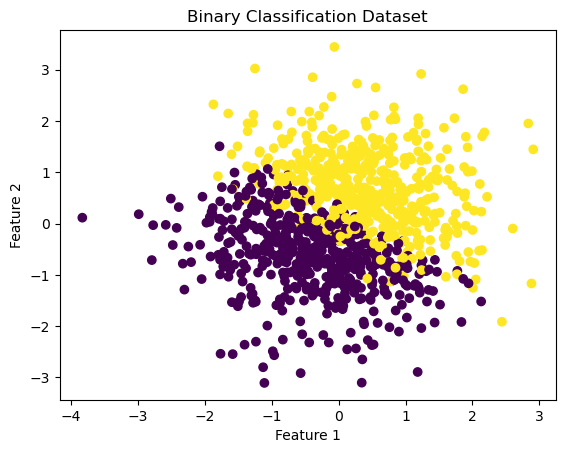

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Parameters
num_samples = 1000
num_features = 2

# Generate random input features
dataset = torch.randn(num_samples, num_features)

# Generate random weights for features
true_weights = torch.randn(num_features, 1)

# Generate target labels based on a linear combination of input features
# and adding some random noise
target_labels = torch.mm(dataset, true_weights) + 0.5 * torch.randn(num_samples, 1)

# Apply a threshold to convert target labels to binary classes
binary_labels = torch.where(target_labels >= 0, torch.tensor(1.0), torch.tensor(0.0))

# Visualize the data
plt.scatter(dataset[:, 0], dataset[:, 1], c=binary_labels.squeeze())
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Classification Dataset')
plt.show()

In [4]:
train_size = int(0.8*dataset.shape[0])

X_train, y_train = dataset[:train_size, :], binary_labels[:train_size]
X_test, y_test = dataset[train_size: , :], binary_labels[train_size: ]

## Model Implementation

In [5]:
class BinaryLogisticRegression(nn.Module):

    def __init__(self, num_features):
        super().__init__()
        self.linear = nn.Linear(num_features, 1)

    def forward(self, x):
        logits = self.linear(x)
        probs = F.sigmoid(logits)
        return probs

In [6]:
def compute_accuracy(y_probs, y_true):
    y_pred = torch.where(y_probs>0.5, 1, 0)
    equal_predictions = torch.sum(y_pred.view(-1) == y_true.view(-1))
    accuracy = int(equal_predictions)/y_true.shape[0]
    return accuracy*100

## Training and Evaluating the model

In [7]:
model = BinaryLogisticRegression(num_features=2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [8]:
num_epochs = 30
loss_list = []

for epoch in range(num_epochs):

    # Ouptut probs
    y_probs = model.forward(X_train)

    # Cost function
    loss = F.binary_cross_entropy(y_probs, y_train)

    # Compute gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

    # Check and log accuracy
    y_probs = model.forward(X_train)
    acc = compute_accuracy(y_probs, y_train)
    print(f"Epoch {epoch+1} | Training Accuracy: {round(acc, 2)}% | Loss: {F.binary_cross_entropy(y_probs, y_train)}")
    loss_list.append(loss.detach().numpy())

Epoch 1 | Training Accuracy: 33.0% | Loss: 0.8866958022117615
Epoch 2 | Training Accuracy: 44.75% | Loss: 0.7705596089363098
Epoch 3 | Training Accuracy: 51.88% | Loss: 0.6804543137550354
Epoch 4 | Training Accuracy: 65.0% | Loss: 0.6115694642066956
Epoch 5 | Training Accuracy: 79.0% | Loss: 0.5587300062179565
Epoch 6 | Training Accuracy: 85.0% | Loss: 0.5175798535346985
Epoch 7 | Training Accuracy: 88.12% | Loss: 0.4848891794681549
Epoch 8 | Training Accuracy: 89.62% | Loss: 0.45838597416877747
Epoch 9 | Training Accuracy: 90.38% | Loss: 0.4364910125732422
Epoch 10 | Training Accuracy: 90.38% | Loss: 0.4180978536605835
Epoch 11 | Training Accuracy: 90.38% | Loss: 0.4024185240268707
Epoch 12 | Training Accuracy: 90.25% | Loss: 0.38888123631477356
Epoch 13 | Training Accuracy: 90.25% | Loss: 0.3770630359649658
Epoch 14 | Training Accuracy: 90.25% | Loss: 0.36664512753486633
Epoch 15 | Training Accuracy: 90.38% | Loss: 0.3573833405971527
Epoch 16 | Training Accuracy: 90.5% | Loss: 0.3490

In [9]:
w = model.linear.weight.data.squeeze()
b = model.linear.bias.data.squeeze()

In [10]:
b.item()

-0.04034833982586861

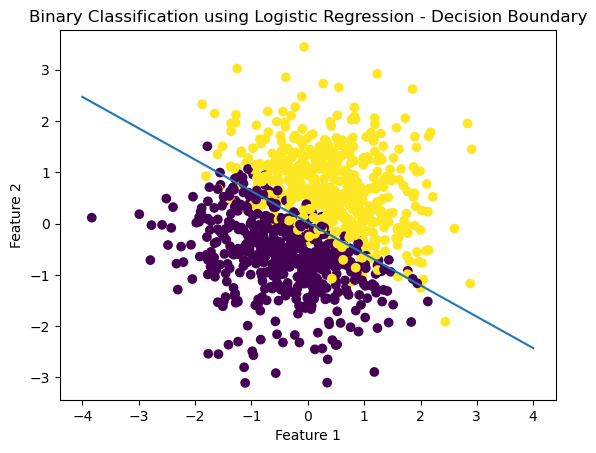

In [11]:
x_min = -4
y_min = ((-(w[0].item() * x_min) - b.item()) / w[1].item() )

x_max = 4
y_max = ( (-(w[0].item() * x_max) - b.item()) / w[1].item() )

# Visualize the data
plt.scatter(dataset[:, 0], dataset[:, 1], c=binary_labels.squeeze())
plt.plot([x_min, x_max], [y_min, y_max])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Classification using Logistic Regression - Decision Boundary')
plt.show()

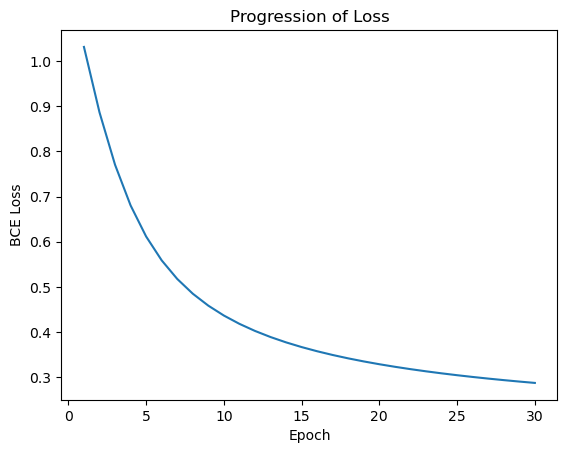

In [12]:
plt.plot(range(1, num_epochs+1), loss_list)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Progression of Loss")
plt.show()

## Test Set Prediction

In [13]:
with torch.no_grad():
    y_probs = model.forward(X_train)
    acc = compute_accuracy(y_probs, y_train)
    print(f"Test Accuracy: {acc}")

Test Accuracy: 90.875


# Multi-class Logistic Regression

## Read Toy dataset

In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/iris.csv')
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [15]:
# Basic pre-processing
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df['y'] = pd.Categorical(pd.factorize(df['y'])[0])
df = df.sample(frac=1)
df.head()

,x1,x2,x3,x4,y
65,6.7,3.1,4.4,1.4,1
39,5.1,3.4,1.5,0.2,0
92,5.8,2.6,4.0,1.2,1
12,4.8,3.0,1.4,0.1,0
84,5.4,3.0,4.5,1.5,1


In [16]:
df['y'].nunique()

3

In [17]:
X = torch.tensor(df[['x1', 'x2', 'x3', 'x4']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

In [18]:
train_size = int(0.8*X.shape[0])

X_train, y_train = X[:train_size, :], y[:train_size]
X_test, y_test = X[train_size: , :], y[train_size: ]

## Model Implementation

In [19]:
class MultiClassLogisticRegression(nn.Module):

    def __init__(self, num_features, num_classes):
        super().__init__()
        self.linear = nn.Linear(num_features, num_classes)

    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [20]:
mc_model = MultiClassLogisticRegression(num_features=4, num_classes=3).to(device)
optimizer = torch.optim.SGD(mc_model.parameters(), lr=0.1)

In [21]:
def compute_mc_accuracy(y_probs, y_true):
    y_pred = torch.argmax(y_probs, dim=1)
    equal_predictions = torch.sum(y_pred.view(-1) == y_true.view(-1))
    accuracy = int(equal_predictions)/y_true.shape[0]
    return accuracy*100

## Training and Evaluating the model

In [22]:
num_epochs = 200
loss_list = []

for epoch in range(num_epochs):

    # Forward pass
    logits, y_probas = mc_model.forward(X_train)

    # Compute loss
    loss = F.cross_entropy(logits, y_train.long())

    # Compute gradients
    optimizer.zero_grad()
    loss.backward()

    # Update weigths
    optimizer.step()

    # Log metrics
    if epoch%5 == 0:
        logits, y_probs = mc_model.forward(X_train)
        acc = compute_mc_accuracy(y_probs, y_train)
        print(f"Epoch {epoch} | Training Accuracy: {round(acc, 2)}% | Loss: {F.cross_entropy(logits, y_train.long())}")
        loss_list.append(loss.detach().numpy())

Epoch 0 | Training Accuracy: 51.67% | Loss: 1.469765543937683
Epoch 5 | Training Accuracy: 36.67% | Loss: 1.0102412700653076
Epoch 10 | Training Accuracy: 65.83% | Loss: 0.8866232633590698
Epoch 15 | Training Accuracy: 67.5% | Loss: 0.8268178701400757
Epoch 20 | Training Accuracy: 65.83% | Loss: 0.7275650501251221
Epoch 25 | Training Accuracy: 67.5% | Loss: 0.7394522428512573
Epoch 30 | Training Accuracy: 65.83% | Loss: 0.6522716283798218
Epoch 35 | Training Accuracy: 67.5% | Loss: 0.6840437650680542
Epoch 40 | Training Accuracy: 65.83% | Loss: 0.6039124727249146
Epoch 45 | Training Accuracy: 67.5% | Loss: 0.6411582827568054
Epoch 50 | Training Accuracy: 65.83% | Loss: 0.5670644044876099
Epoch 55 | Training Accuracy: 67.5% | Loss: 0.6042131185531616
Epoch 60 | Training Accuracy: 66.67% | Loss: 0.53612220287323
Epoch 65 | Training Accuracy: 67.5% | Loss: 0.570476770401001
Epoch 70 | Training Accuracy: 68.33% | Loss: 0.5085529685020447
Epoch 75 | Training Accuracy: 67.5% | Loss: 0.538658

## Test Set Prediction

In [23]:
with torch.no_grad():
    logits, y_probs = mc_model.forward(X_test)
    acc = compute_mc_accuracy(y_probs, y_test)
    print(f"Test Accuracy: {acc}")

Test Accuracy: 100.0


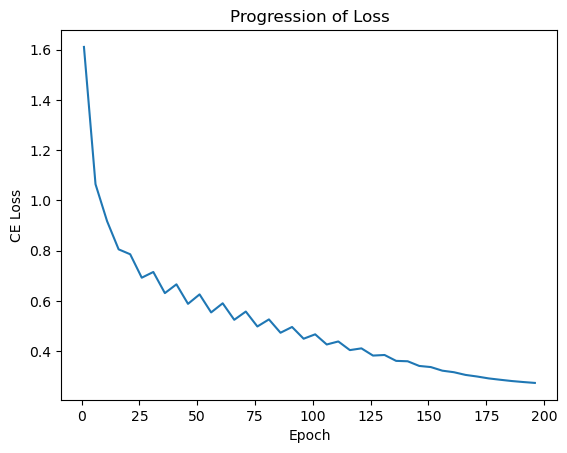

In [24]:
plt.plot(range(1, num_epochs+1, 5), loss_list)
plt.xlabel("Epoch")
plt.ylabel("CE Loss")
plt.title("Progression of Loss")
plt.show()